In [2]:
import numpy as np
from keras import layers , activations , models , preprocessing, optimizers, callbacks, preprocessing, utils
from matplotlib import pyplot as plt
import os
import yaml
import requests, zipfile, io
from re import findall, sub
from collections import Counter
from tqdm import tqdm
from pickle import dump, load

%matplotlib inline
callbacks = [callbacks.EarlyStopping(monitor='loss', patience=2)]

In [18]:
def tokk():
    with open('dialogues.txt', encoding='utf-8') as file:
        content = file.read().lower()
        content = " ".join(findall(r'[\n\w-]+', content)[:5 * 10 ** 5])
        counter = Counter(content.split())
    for word in tqdm(counter):
        if counter[word] < 10:
            content = sub(" " + word + " ", ' ', content)
    content = content.split('\n\n')
    return content

In [19]:
content = tokk()

questions = []
answers = []

for con in tqdm(content):
    con = [i.strip() for i in con.split('-')][1:]
    con = con if not len(con) % 2 else con[:-1]
    questions.extend([st for index, st in enumerate(con) if not index % 2])
    answers.extend(['<START> ' + st + ' <END>' for index, st in enumerate(con) if index % 2])
    
tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(questions + answers)
VOCAB_SIZE = len(tokenizer.word_index) + 1
print('VOCAB SIZE : {}'.format(VOCAB_SIZE))

100%|████████████████████████████████████████████████████████████████████████| 34092/34092 [00:00<00:00, 239851.40it/s]


VOCAB SIZE : 4182


In [5]:
dump(tokenizer, open('tokenizer_vocab', "wb"))

In [20]:
# encoder_input_data
tokenized_questions = tokenizer.texts_to_sequences(questions)
maxlen_questions = max([len(x) for x in tokenized_questions])
padded_questions = preprocessing.sequence.pad_sequences(tokenized_questions, maxlen=maxlen_questions, padding='post')
encoder_input_data = np.array(padded_questions)
print(encoder_input_data.shape, maxlen_questions)

# decoder_input_data
tokenized_answers = tokenizer.texts_to_sequences(answers)
maxlen_answers = max([len(x) for x in tokenized_answers])
padded_answers = preprocessing.sequence.pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')
decoder_input_data = np.array(padded_answers)
print(decoder_input_data.shape, maxlen_answers)

# decoder_output_data
tokenized_answers = tokenizer.texts_to_sequences(answers)
for i in range(len(tokenized_answers)):
    tokenized_answers[i] = tokenized_answers[i][1:]
padded_answers = preprocessing.sequence.pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')
onehot_answers = utils.to_categorical(padded_answers, VOCAB_SIZE)
decoder_output_data = np.array(onehot_answers)
print(decoder_output_data.shape)

# Saving all the arrays to storage
np.save('enc_in_data.npy', encoder_input_data)
np.save('dec_in_data.npy', decoder_input_data)
np.save('dec_tar_data.npy', decoder_output_data)

(45057, 13) 13
(45057, 15) 15
(45057, 15, 4182)


In [3]:
encoder_input_data = np.load('enc_in_data.npy')
decoder_input_data = np.load('dec_in_data.npy')
decoder_output_data = np.load('dec_tar_data.npy')

In [5]:
VOCAB_SIZE = 4182

In [7]:
encoder_inputs = layers.Input(shape=(None, ))
encoder_embedding = layers.Embedding(VOCAB_SIZE, 200, mask_zero=True)(encoder_inputs)
_, state_h, state_c = layers.LSTM(200, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = layers.Input(shape=(None, ))
decoder_embedding = layers.Embedding(VOCAB_SIZE, 200, mask_zero=True)(decoder_inputs)
decoder_lstm = layers.LSTM(200, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = layers.Dense(VOCAB_SIZE, activation=activations.softmax) 
output = decoder_dense(decoder_outputs)

model = models.Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 200)    836400      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 200)    836400      input_5[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LS

In [8]:
history = model.fit([encoder_input_data , decoder_input_data], 
                    decoder_output_data,
                    batch_size=64,
                    callbacks=callbacks,
                    epochs=500,
                    verbose=False) 
model.save( 'model.h5' ) 

W0904 01:59:30.296724  4176 deprecation_wrapper.py:119] From C:\Users\Bogdan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

C:\Users\Bogdan\Anaconda3\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_2:0' shape=(?, 200) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 200) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


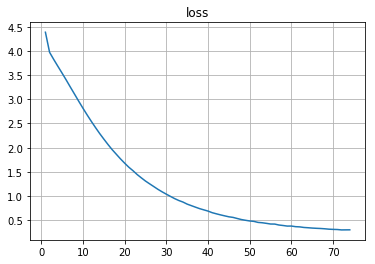

In [9]:
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
plt.title('loss')
plt.grid(True)

In [10]:
def make_inference_models():
    encoder_model = models.Model(encoder_inputs, encoder_states)
    
    decoder_states_inputs = [layers.Input(shape=(200, )), layers.Input(shape=(200, ))]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = models.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs, state_h, state_c])
    return encoder_model, decoder_model



def str_to_tokens(sentence):
    tokens_list = [tokenizer.word_index[word] for word in sentence.lower().split()]
    return preprocessing.sequence.pad_sequences([tokens_list], maxlen=maxlen_questions, padding='post')

In [11]:
model.load_weights('model.h5')

In [14]:
tokenizer = load(open('tokenizer_vocab', 'rb'))

In [22]:
enc_model , dec_model = make_inference_models()

for i in range(10):
    states_values = enc_model.predict(str_to_tokens(input('\nEnter question : ')))
    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    count = 0
    while True:
        count += 1
        dec_outputs, h, c = dec_model.predict([empty_target_seq] + states_values)
        sampled_word_index = np.argmax(dec_outputs)
        sampled_word = tokenizer.index_word[sampled_word_index]
        if sampled_word == 'end' or count > maxlen_answers:
            break
            
        print(sampled_word, end=' ')
        empty_target_seq[0, 0] = sampled_word_index
        states_values = [h ,c] 


Enter question : привет
привет 
Enter question : как дела
так себе 
Enter question : что делаешь
как видишь 
Enter question : ты где
тут 
Enter question : сколько тебе лет
какая разница 
Enter question : как тебя зовут
найл 
Enter question : красиво
э 
Enter question : что
то я тебе 
Enter question : не приятно
может не быть этого вы уже знаешь 
Enter question : ну спасибо


***